## Imports

In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [3]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [4]:
 def apply_correction(self, u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [5]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

### Data

In [6]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

In [7]:
N = 300

## Revisiting gridding to impose hermitian property

In [8]:
class Gridding(object):
    def __init__(self, N, Rmax, FT):
        self._N = N
        self._Rmax = Rmax
        self._FT =  FT

    def run(self, u, v, Vis, Weights, type = 'weighted', shift = False): 
        # Calculating bin edges.
        bin_centers = self.edges_centers(self._FT._u)[0]
        bin_edges_u = self.edges_centers(self._FT._u)[1]
        bin_edges_v = self.edges_centers(self._FT._v)[1]

        if type == 'weighted':
            u_gridded, v_gridded, vis_gridded, weights_gridded = self.weighted_gridding(u, v, Vis, Weights,
                                                                                        bin_centers, bin_edges_u, bin_edges_v, shift = shift)

        return u_gridded, v_gridded, vis_gridded, weights_gridded

    def edges_centers(self, freq):
        correction = (freq[1] - freq[0])/2
        
        # Creating the grid with shifted scheme.
        bin_centers = np.fft.fftshift(freq)
        edges_=  bin_centers - correction
        edges = np.concatenate((edges_, [edges_[-1] + 2*correction]))
        return bin_centers, edges
    
    def weighted_gridding(self, u, v, Vis, Weights, centers, edges_u, edges_v, shift = False):
        # Calculating values in grid
        vis_weights_sum_bin, _, _, _ = binned_statistic_2d(u, v, Vis*Weights, 'sum', bins=[edges_u, edges_v], expand_binnumbers = False)
        weights_sum_bin, _, _, _ = binned_statistic_2d(u, v, Weights, 'sum', bins=[edges_u, edges_v], expand_binnumbers = False)
        vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin
        weights_gridded_matrix, _, _, _ = binned_statistic_2d(u, v, Weights, 'sum', bins=[edges_u, edges_v], expand_binnumbers = False)

        # Change Nans by 0 in vis.
        vis_gridded = np.nan_to_num(vis_gridded_matrix, nan=0)
        weights_gridded = np.nan_to_num(weights_gridded_matrix, nan=0)

        if shift:
            u_gridded, v_gridded, vis_gridded, weights_gridded = self.shiftting(centers, vis_gridded, weights_gridded)
    
        else:
            u_gridded, v_gridded = self._FT._Un, self._FT._Vn # unshifted by default.
            vis_gridded = np.fft.fftshift(vis_gridded).flatten()
            weights_gridded = np.fft.fftshift(weights_gridded).flatten()

        # Change Nans by 0 in vis again.
        vis_gridded = np.nan_to_num(vis_gridded, nan=0)
        weights_gridded = np.nan_to_num(weights_gridded, nan=0)
            
        return u_gridded, v_gridded, vis_gridded, weights_gridded


    def shiftting(self, freqs, vis_matrix, weights_matrix):
        vis_gridded = vis_matrix.flatten()
        weights_gridded = weights_matrix.flatten()
        u_, v_ = np.meshgrid(freqs, freqs, indexing='ij') 
        u_gridded, v_gridded = u_.reshape(-1), v_.reshape(-1)
        return u_gridded, v_gridded, vis_gridded, weights_gridded


In [9]:
frank2d = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
FT = frank2d._FT

In [10]:
Grid = Gridding(N, frank2d._Rmax, frank2d._FT)

In [11]:
u_grid, v_grid, vis_grid, weights_grid = Grid.run(u_deproj, v_deproj, vis_deproj, Weights)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_11157/3891542673.py:32: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


In [12]:
x_labels = np.fft.fftshift(FT._u/1e6)
y_labels = np.fft.fftshift(FT._v/1e6)

num_ticks = 5
x_ticks_to_show = np.linspace(0, len(x_labels) - 1, num_ticks).astype(int)
y_ticks_to_show = np.linspace(0, len(y_labels) - 1, num_ticks).astype(int)

def format_labels(x):
    return f"{int(x):d}" if abs(x) > 1e-8 else "0"

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_11157/1610342996.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_grid.real.reshape(FT._Nx, FT._Ny)))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')


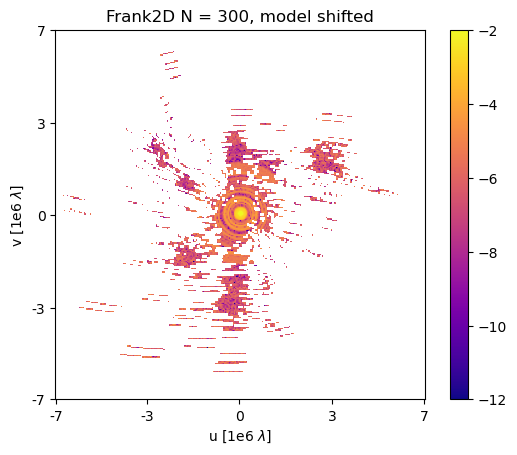

In [13]:
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_grid.real.reshape(FT._Nx, FT._Ny)))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')
plt.title(F'Frank2D N = {N}, model shifted')
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

In [14]:
class HermitianGridding(object):
    def __init__(self, N, Rmax, FT):
        self._N = N
        self._Rmax = Rmax
        self._FT =  FT

    def run(self, u, v, Vis, Weights, type = 'weighted', shift = False): 
        # Calculating bin edges.
        bin_centers = self.edges_centers(self._FT._u)[0]
        bin_edges_u = self.edges_centers(self._FT._u)[1]
        bin_edges_v = self.edges_centers(self._FT._v)[1]

        if type == 'weighted':
            u_gridded, v_gridded, vis_gridded, weights_gridded = self.weighted_gridding(u, v, Vis, Weights,
                                                                                        bin_centers, bin_edges_u, bin_edges_v, shift = shift)

        return u_gridded, v_gridded, vis_gridded, weights_gridded

    def edges_centers(self, freq):
        correction = (freq[1] - freq[0])/2
        
        # Creating the grid with shifted scheme.
        bin_centers = np.fft.fftshift(freq)
        edges_=  bin_centers - correction
        edges = np.concatenate((edges_, [edges_[-1] + 2*correction]))
        return bin_centers, edges
    
    def weighted_gridding(self, u, v, Vis, Weights, centers, edges_u, edges_v, shift = False):
        # calculating values in grid
        vis_weights_sum_bin, _, _, _ = binned_statistic_2d(u, v, Vis*Weights, 'sum', bins=[edges_u, edges_v], expand_binnumbers = False)
        weights_sum_bin, _, _, _ = binned_statistic_2d(u, v, Weights, 'sum', bins=[edges_u, edges_v], expand_binnumbers = False)
        vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin
        weights_gridded_matrix, _, _, _ = binned_statistic_2d(u, v, Weights, 'sum', bins=[edges_u, edges_v], expand_binnumbers = False)

        # change Nans by 0 in vis.
        vis_gridded_ = np.nan_to_num(vis_gridded_matrix, nan=0)
        weights_gridded_ = np.nan_to_num(weights_gridded_matrix, nan=0)

        # Imposing hermitian conjugate property.
        vis_gridded, weights_gridded = self.enforce_hermitian_symmetry(vis_gridded_, weights_gridded_)

        if shift:
            u_gridded, v_gridded, vis_gridded, weights_gridded = self.shiftting(centers, vis_gridded, weights_gridded)
    
        else:
            u_gridded, v_gridded = self._FT._Un, self._FT._Vn # unshifted by default.
            vis_gridded = np.fft.fftshift(vis_gridded).flatten()
            weights_gridded = np.fft.fftshift(weights_gridded).flatten()

        vis_gridded_ = np.nan_to_num(vis_gridded_matrix, nan=0)
        weights_gridded_ = np.nan_to_num(weights_gridded_matrix, nan=0)

        return u_gridded, v_gridded, vis_gridded, weights_gridded

    def enforce_hermitian_symmetry(self, vis, weights):
        N_x, N_y = vis.shape
        vis_symmetric = vis.copy()
        weights_symmetric = weights.copy()
    
        center_x, center_y = N_x // 2, N_y // 2
    
        for i in range(center_x, N_x):  # Recorrer la mitad derecha
            for j in range(N_y):   
                i_sym = (2 * center_x - i) % N_x
                j_sym = (2 * center_y - j) % N_y
    
                v_uv = vis_symmetric[i, j]
                v_neg_uv = vis_symmetric[i_sym, j_sym]
    
                if np.abs(v_neg_uv.real) != np.abs(v_uv.real):
                    w_neg_uv = weights_symmetric[i_sym, j_sym]
                    w_uv = weights_symmetric[i, j]
                    w_final = w_neg_uv + w_uv
                    val = (np.conj(v_neg_uv)*w_neg_uv + v_uv*w_uv)/w_final
                    vis_symmetric[i, j] = val
                    vis_symmetric[i_sym, j_sym] = np.conj(val)
                    weights_symmetric[i, j] = w_final
                    weights_symmetric[i_sym, j_sym] = w_final
    
        return vis_symmetric, weights_symmetric

    def shiftting(self, freqs, vis_matrix, weights_matrix):
        vis_gridded = vis_matrix.flatten()
        weights_gridded = weights_matrix.flatten()
        u_, v_ = np.meshgrid(freqs, freqs, indexing='ij') 
        u_gridded, v_gridded = u_.reshape(-1), v_.reshape(-1)
        return u_gridded, v_gridded, vis_gridded, weights_gridded


In [15]:
Grid2 = HermitianGridding(N, frank2d._Rmax, frank2d._FT)

In [16]:
u_grid2, v_grid2, vis_grid2, weights_grid2 = Grid2.run(u_deproj, v_deproj, vis_deproj, Weights)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_11157/2175023175.py:32: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


In [17]:
vis_grid22, weights_grid22 = Grid2.enforce_hermitian_symmetry(vis_grid.reshape(FT._Nx, FT._Ny), weights_grid.reshape(FT._Nx, FT._Ny))

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_11157/1775470757.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift((vis_grid2.reshape(FT._Nx, FT._Ny)).real))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')


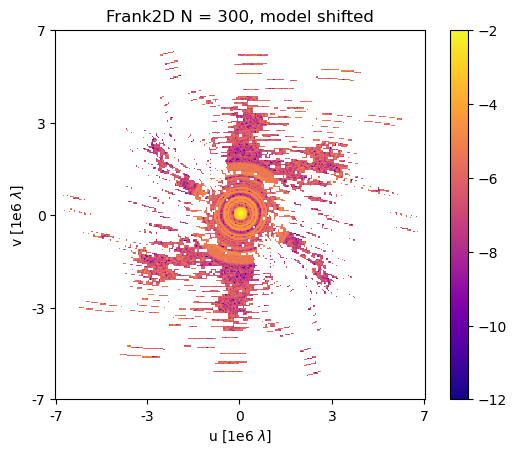

In [18]:
plt.imshow(np.log(np.abs(np.fft.fftshift((vis_grid2.reshape(FT._Nx, FT._Ny)).real))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')
plt.title(F'Frank2D N = {N}, model shifted')
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_11157/3330643164.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift((vis_grid2 - vis_grid).real.reshape(FT._Nx, FT._Ny)))), vmin=-12, vmax=-2, origin = 'lower')


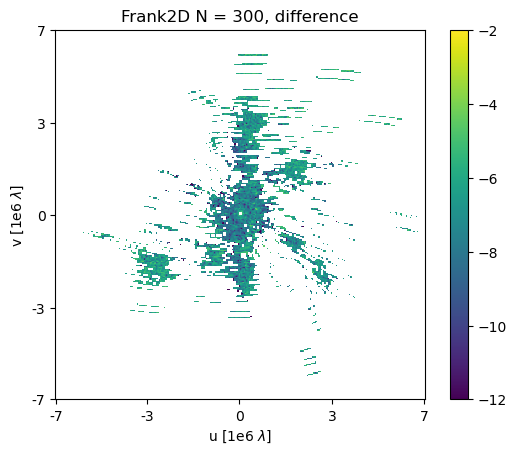

In [19]:
plt.imshow(np.log(np.abs(np.fft.fftshift((vis_grid2 - vis_grid).real.reshape(FT._Nx, FT._Ny)))), vmin=-12, vmax=-2, origin = 'lower')
plt.title(F'Frank2D N = {N}, difference')
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

In [20]:
len(np.where((v_grid == FT._Vn) == False)[0])

0

# Frank2D

In [21]:
m, c, l = -0.33, -0.1, 2e5

#### 1 (without Hermitian Conjugate Property)

In [202]:
start_time = time.time()

#####

frank2d = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d.set_gridded_data(u_grid, v_grid, vis_grid, weights_grid)
frank2d.set_kernel('Wendland', [m, c, l])
frank2d.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting gridded data...
Setting kernel: Wendland...
Gridding...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 5.13  min |  307.77 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 7.168237585954344e-08
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
  

In [155]:
vis_sol = frank2d.sol_visibility.reshape(FT._Nx, FT._Ny)

Inverting with 2fft ...
  --> time = 0.00  min |  0.01 seconds


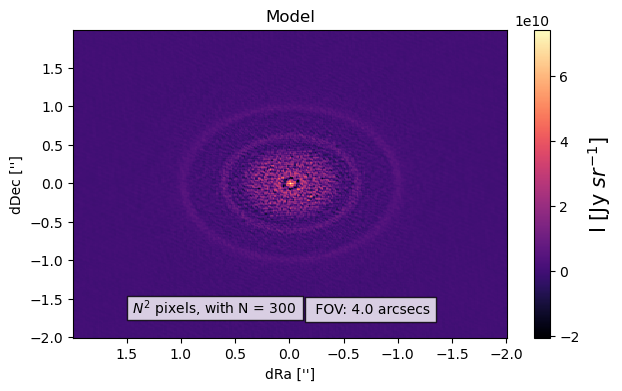

In [156]:
frank2d.fft()
Plot(frank2d).get_image()

In [157]:
r, I = get_radial_profile(frank2d)

In [158]:
start_time = time.time()

#####

frank2d_im = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d_im.set_gridded_data(u_grid, v_grid, vis_grid.imag, weights_grid)
frank2d_im.set_kernel('Wendland', [m, c, l])
frank2d_im.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting gridded data...
Setting kernel: Wendland...
Gridding...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 6.34  min |  380.55 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 4.1320144950591026e-10
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. iteration:  18
 

In [159]:
vis_sol_imag = frank2d_im.sol_visibility.reshape(FT._Nx, FT._Ny)

In [160]:
frank2d_tot = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
vis_sol_tot = vis_sol + vis_sol_imag*1j
frank2d_tot.sol_visibility = vis_sol_tot

Inverting with 2fft ...
  --> time = 0.00  min |  0.01 seconds


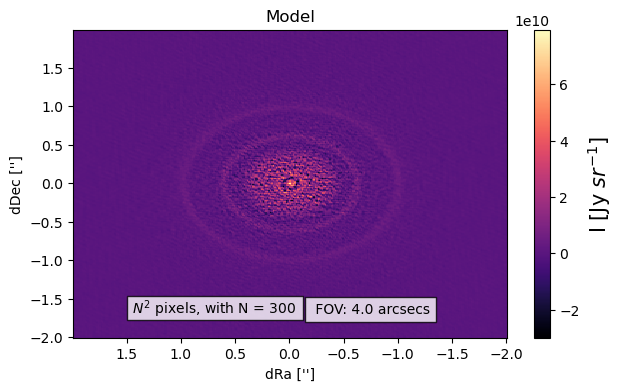

In [162]:
frank2d_tot.fft()
Plot(frank2d_tot).get_image()

In [163]:
r_tot, I_tot = get_radial_profile(frank2d_tot)

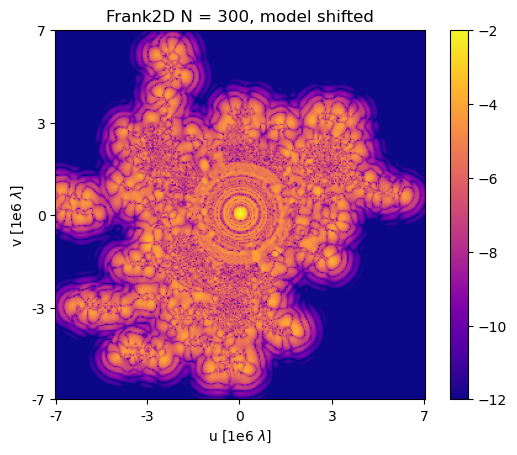

In [164]:
plt.imshow(np.log(np.abs(np.fft.fftshift((vis_sol_tot).real.reshape(FT._Nx, FT._Ny)))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')
plt.title(F'Frank2D N = {N}, model shifted')
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

### 2 (with Hermitian Conjugate Property)

In [22]:
m, c, l = -0.33, -0.1, 2e5

In [23]:
start_time = time.time()

#####

frank2d2 = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d2.set_gridded_data(u_grid2, v_grid2, vis_grid2, weights_grid2)
frank2d2.set_kernel('Wendland', [m, c, l])
frank2d2.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting gridded data...
Setting kernel: Wendland...
Deprojecting...
Gridding...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 10.20  min |  612.02 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 1.3769214646992301e-07
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             ..

In [24]:
vis_sol2 = frank2d2.sol_visibility.reshape(FT._Nx, FT._Ny)

Inverting with 2fft ...
  --> time = 0.00  min |  0.01 seconds


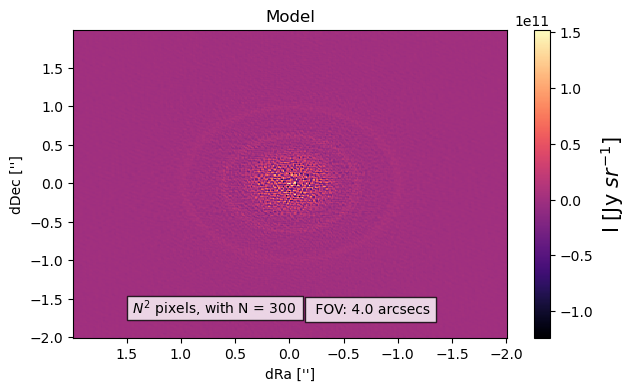

In [32]:
frank2d2.fft()
Plot(frank2d2).get_image()

In [34]:
r2, I2 = get_radial_profile(frank2d2)

In [26]:
start_time = time.time()

#####

frank2d2_re = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d2_re.set_gridded_data(u_grid2, v_grid, vis_grid2.real, weights_grid2)
frank2d2_re.set_kernel('Wendland', [m, c, l])
frank2d2_re.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting gridded data...
Setting kernel: Wendland...
Deprojecting...
Gridding...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 9.02  min |  541.24 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 1.3768968794601003e-07
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. 

In [27]:
start_time = time.time()

#####

frank2d2_im = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d2_im.set_gridded_data(u_grid2, v_grid, vis_grid2.imag, weights_grid2)
frank2d2_im.set_kernel('Wendland', [m, c, l])
frank2d2_im.fit(u, v, Vis, Weights, method = 'bicgstab', rtol = 1e-15, frank1d_guess = False)

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting gridded data...
Setting kernel: Wendland...
Deprojecting...
Gridding...
Setting fit with bicgstab ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
Setting A...
Setting A_precond...
Setting b...
     --> time = 9.20  min |  551.96 seconds
  *  Solving linear system...
     * BICGSTAB
         * rtol: 1e-15
         * final tolerance: 8.228200441845146e-10
         * maxiter:  900000
             .. iteration:  0
             .. iteration:  1
             .. iteration:  2
             .. iteration:  3
             .. iteration:  4
             .. iteration:  5
             .. iteration:  6
             .. iteration:  7
             .. iteration:  8
             .. iteration:  9
             .. iteration:  10
             .. iteration:  11
             .. iteration:  12
             .. iteration:  13
             .. iteration:  14
             .. iteration:  15
             .. iteration:  16
             .. iteration:  17
             .. i

In [29]:
frank2d2_tot = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
vis_sol2_tot = frank2d2_re.sol_visibility.reshape(FT._Nx, FT._Ny) + frank2d2_im.sol_visibility.reshape(FT._Nx, FT._Ny)*1j
frank2d2_tot.sol_visibility = vis_sol2_tot

Inverting with 2fft ...
  --> time = 0.00  min |  0.01 seconds


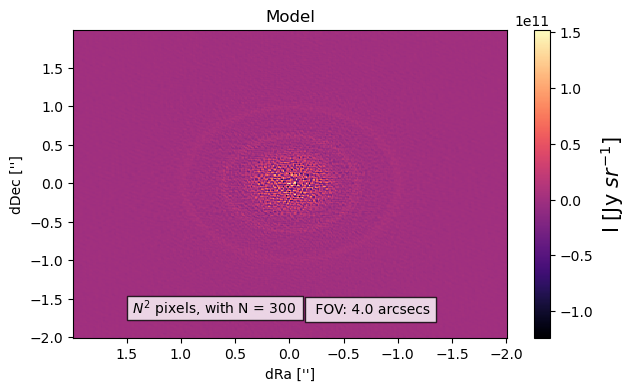

In [33]:
frank2d2_tot.fft()
Plot(frank2d2_tot).get_image()

In [35]:
r2_tot, I2_tot = get_radial_profile(frank2d2_tot)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_11157/2722648959.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift((vis_sol2).real.reshape(FT._Nx, FT._Ny)))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')


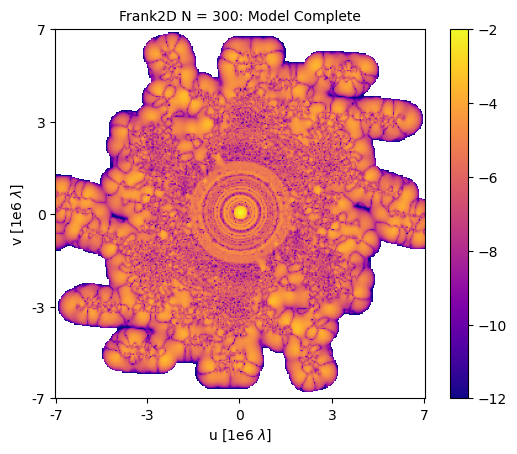

In [40]:
plt.imshow(np.log(np.abs(np.fft.fftshift((vis_sol2).real.reshape(FT._Nx, FT._Ny)))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')
plt.title(F'Frank2D N = {N}: Model Complete', size =  10)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

## Comparing solutions

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_11157/1933307248.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift((vis_sol2 - vis_sol2_tot).real.reshape(FT._Nx, FT._Ny)))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')


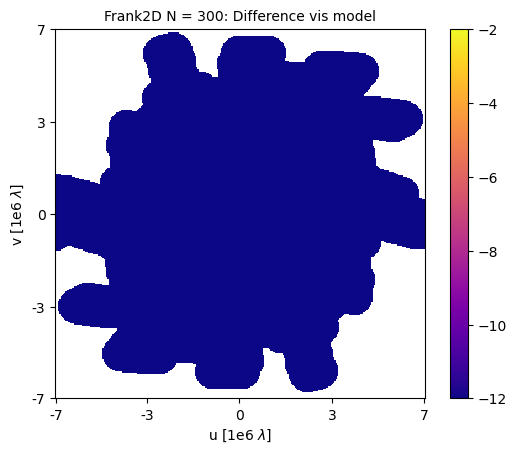

In [41]:
plt.imshow(np.log(np.abs(np.fft.fftshift((vis_sol2 - vis_sol2_tot).real.reshape(FT._Nx, FT._Ny)))), vmin=-12, vmax=-2, origin = 'lower', cmap = 'plasma')
plt.title(F'Frank2D N = {N}: Difference vis model', size =  10)
plt.xticks(ticks=x_ticks_to_show, labels=[format_labels(x) for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[format_labels(y) for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel(r'u [1e6 $\lambda$]')
plt.ylabel(r'v [1e6 $\lambda$]')
plt.colorbar()

In [42]:
frank2d_comp = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d_comp.sol_intensity = frank2d2.sol_intensity - frank2d2_tot.sol_intensity

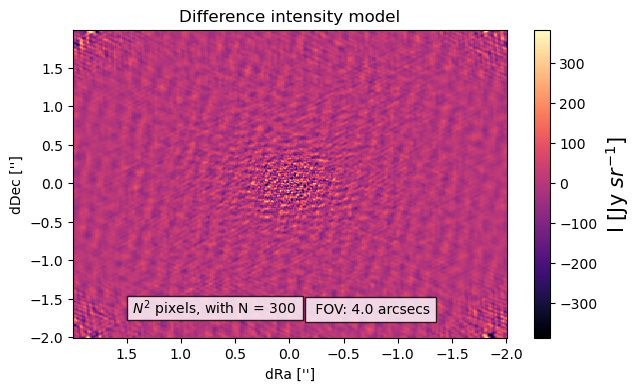

In [43]:
Plot(frank2d_comp).get_image('Difference intensity model')

In [45]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

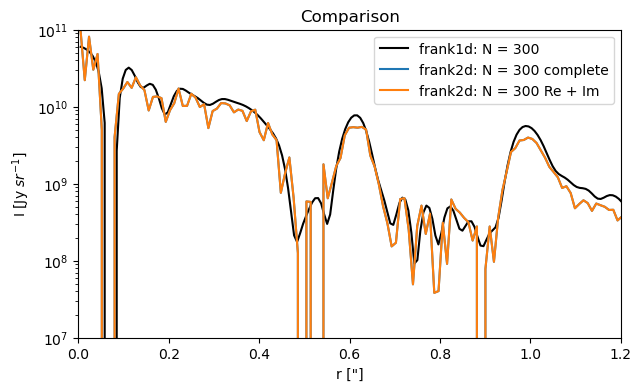

In [48]:
plt.figure(figsize=(7,4))
plt.plot(sol.r, sol.mean, 'black',label =f'frank1d: N = {n_pts}')
plt.plot(r2, I2, label = f'frank2d: N = {N} complete')
plt.plot(r2_tot, I2_tot, label = f'frank2d: N = {N} Re + Im')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)    
plt.ylim(1e7, 1e11)
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.title("Comparison")
plt.legend()
plt.yscale("log")
plt.show()

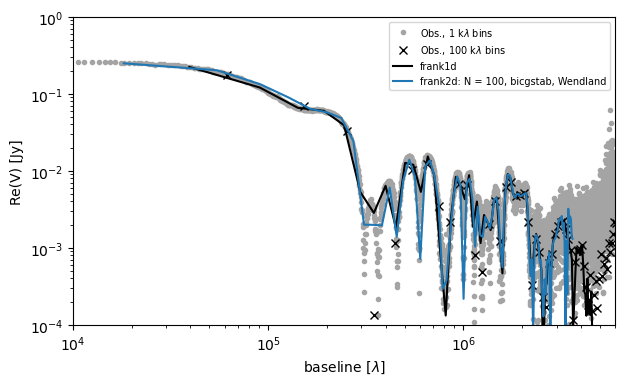

In [173]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))


#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_1= get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_1.real), label = f'frank2d: N = {N}, bicgstab, Wendland')

plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend(fontsize =7)
plt.show()

### Comparing with CLEAN

In [195]:
# Obtain the radial profiles convolved to a circular beam.
from gofish import imagecube

infile_1mm = dir + 'AS209_1mm_13s_conv_circ.fits'
#2D->1D
cube_1mm = imagecube(infile_1mm)
x_1mm,y_1mm,dy_1mm = cube_1mm.radial_profile(inc=inc, PA=pa, x0=dra, y0=ddec)

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


In [196]:
from frank.utilities import convolve_profile

clean_beam_1mm = {'bmaj':0.0373, 'bmin':0.0373, 'beam_pa':31.040}
area_1mm = clean_beam_1mm['bmaj']*clean_beam_1mm['bmin']*np.pi/4./np.log(2.)*(1/rad_to_arcsec)**2

convolved_1mm_frank2d = convolve_profile(r2_tot, I2_tot, inc, pa, clean_beam_1mm)*area_1mm
convolved_1mm_frank1d = convolve_profile(sol.r, sol.mean, inc, pa, clean_beam_1mm)*area_1mm

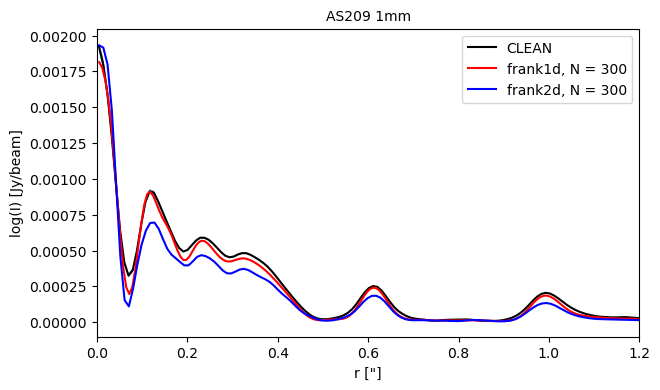

In [197]:
plt.figure(figsize=(7, 4))
plt.plot(x_1mm, y_1mm, "black", label = "CLEAN")
plt.fill_between(x_1mm, y_1mm-dy_1mm, y_1mm+dy_1mm,alpha=0.7)
plt.plot(sol.r, convolved_1mm_frank1d, "red", label=r'frank1d' + ', N = ' +str(n_pts))
plt.plot(r,convolved_1mm_frank2d, "blue", label=r'frank2d' + ', N = ' +str(N))
plt.title(r'AS209 1mm', size=10)
plt.ylabel("log(I) [Jy/beam]", size=10)
plt.xlabel('r ["]', size=10)
plt.legend(fontsize=10)
#plt.yscale('log')
#plt.ylim(0.1e-5, 0.5e-2)
plt.xlim(0,1.2)
plt.show()

## Calculating correlation lenght according to paper

In [167]:
matriz = np.fft.fftshift(vis_sol).real
num_filas, num_columnas = vis_sol.shape
fila_central = FT._Nx // 2
columna_central = FT._Ny // 2

seccion_horizontal = matriz[fila_central, :]

# Sección transversal vertical (a lo largo de la columna central)
seccion_vertical = matriz[:, columna_central]

In [168]:
pico_indice = np.argmax(seccion_horizontal)
pico_valor = seccion_horizontal[pico_indice]

half_peak = 0.5 * pico_valor

# Usar interpolación para encontrar el punto exacto donde cae al 50%
from scipy.interpolate import interp1d

# Crear una función de interpolación lineal
x = np.fft.fftshift(FT._u)
interp_func = interp1d(seccion_horizontal - half_peak, x, kind='linear', bounds_error=False, fill_value="extrapolate")

# Encontrar los índices donde la sección transversal cruza el 50% del pico
indices = np.where(seccion_horizontal >= half_peak)[0]
if len(indices) > 0:
    indice_50_izq = indices[0]  # Índice más cercano al 50% a la izquierda
    indice_50_der = indices[-1]  # Índice más cercano al 50% a la derecha
else:
    indice_50_izq, indice_50_der = None, None  # Caso en el que no cruza


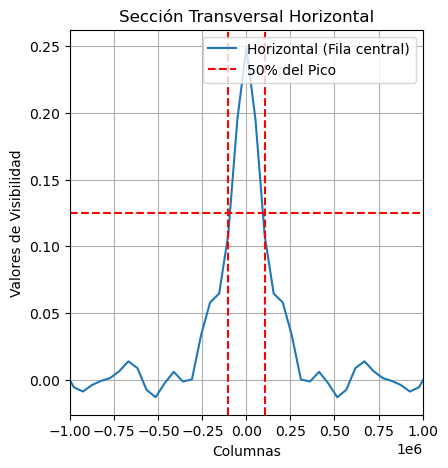

In [169]:
# Graficar las secciones transversales
plt.figure(figsize=(10, 5))

# Gráfico de la sección horizontal
plt.subplot(1, 2, 1)
plt.plot(np.fft.fftshift(FT._u), seccion_horizontal, label='Horizontal (Fila central)')
plt.title('Sección Transversal Horizontal')
plt.xlabel('Columnas')
plt.ylabel('Valores de Visibilidad')
plt.axhline(half_peak, color='red', linestyle='--', label="50% del Pico")
plt.axvline(np.fft.fftshift(FT._u)[indice_50_izq-1], color='red', linestyle='--')
plt.axvline(np.fft.fftshift(FT._u)[indice_50_der+1], color='red', linestyle='--')
plt.xlim(-1e6, 1e6)
plt.grid()
plt.legend(loc= 'best')

In [170]:
correlation_length = np.fft.fftshift(FT._u)[indice_50_der+1]
correlation_length

103132.40312354818

In [171]:
np.abs(FT._Un[1] - FT._Vn[2])/1e5

1.0313240312354819

Text(0.5, 1.0, 'Frank2D N = 300, model unshifted')

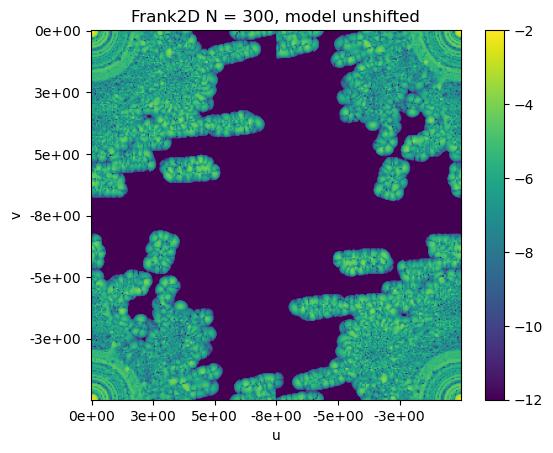

In [75]:
x_labels = FT._u/1e6
y_labels = FT._v/1e6
x_ticks_to_show = np.arange(0, len(x_labels), FT._Nx//6)
y_ticks_to_show = np.arange(0, len(y_labels), FT._Ny//6)

plt.imshow(np.log(np.abs(vis_sol.real)), vmin=-12, vmax=-2)
plt.colorbar()

plt.xticks(ticks=x_ticks_to_show, labels=[f"{x:.0e}" for x in np.array(x_labels)[x_ticks_to_show]])
plt.yticks(ticks=y_ticks_to_show, labels=[f"{y:.0e}" for y in np.array(y_labels)[y_ticks_to_show]])
plt.xlabel('u')
plt.ylabel('v')

plt.title(F'Frank2D N = {N}, model unshifted')

## IRFFT2

We need only the positive frequencies

##### option 1: u > 0

In [893]:
vis_sol_reduced = vis_sol[:, :FT._Ny //2+1]

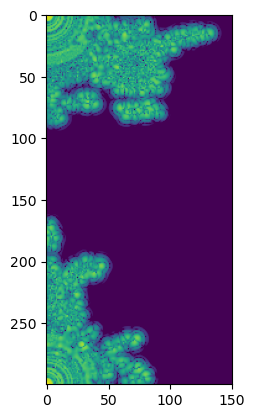

In [894]:
plt.imshow(np.log(np.abs(vis_sol_reduced.real)),vmin=-12, vmax=-2)

##### option 2: v > 0

In [645]:
vis_sol_reduced_2 = vis_sol[:FT._Ny //2, :]

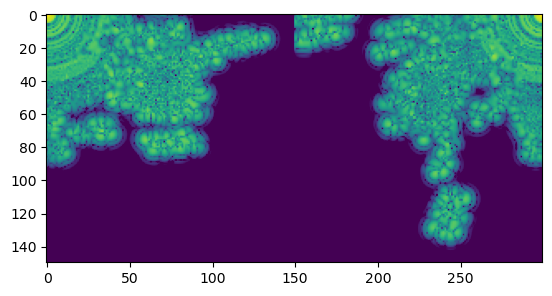

In [646]:
plt.imshow(np.log(np.abs(vis_sol_reduced_2.real)),vmin=-12, vmax=-2)

#### Let's reconstruct inmediatly the vis solution

In [588]:
vis_sol_reduced.shape

(300, 151)

##### from shifted scheme

In [573]:
vis_sol_reduced_shifted = np.fft.fftshift(vis_sol)[:, FT._Ny //2:]

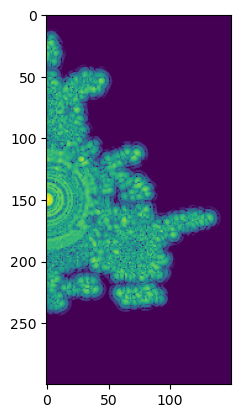

In [592]:
plt.imshow(np.log(np.abs(vis_sol_reduced_shifted.real)),vmin=-12, vmax=-2)

In [629]:
vis_full_shifted = np.zeros((FT._Nx, FT._Ny), dtype=complex)

vis_full_shifted[:, FT._Ny // 2:] = vis_sol_reduced_shifted.copy()

# constructing top-left panel
vis_full_shifted[1:(FT._Nx // 2-1), :FT._Ny // 2] = np.conj(
    np.flip(vis_sol_reduced_shifted[(FT._Nx//2+2):, :], axis=(0, 1))
)

# constructing bottom-left panel
vis_full_shifted[FT._Nx // 2-1:, :FT._Ny // 2] = np.conj(
    np.flip(vis_sol_reduced_shifted[1:FT._Nx // 2+2, :], axis=(0, 1))
)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_62403/1244709547.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(vis_full_shifted.real)), extent = extent, vmin=-12, vmax=-2)


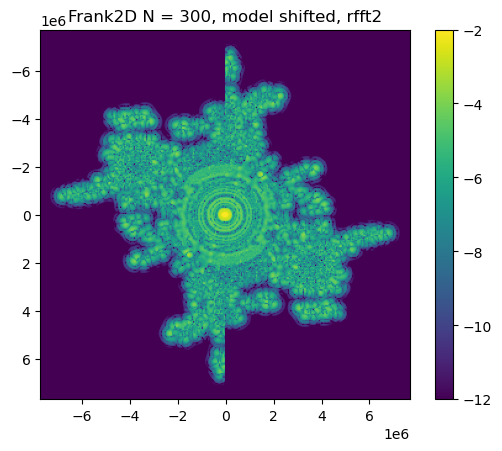

In [634]:
plt.clf()
plt.imshow(np.log(np.abs(vis_full_shifted.real)), extent = extent, vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, model shifted, rfft2')
plt.colorbar()

##### from unshifted scheme (doesn't work)

In [553]:
vis_sol_full = np.zeros((FT._Nx, FT._Ny), dtype=complex)

vis_sol_full[:, :FT._Ny // 2] = vis_sol_reduced.copy()

# Completar frecuencias negativas de v usando la simetría Hermitiana
for u_idx in range(FT._Nx):
    for v_idx in range(0, FT._Ny // 2): 
        if u_idx <= FT._Nx // 2:  # Cuadrante superior derecho
            vis_sol_full[u_idx, FT._Ny // 2 + v_idx] = np.conj(
                vis_sol_reduced[FT._Nx - 1 - u_idx, FT._Ny // 2 - 1 - v_idx]
            )
        else:  # Cuadrante inferior derecho
            vis_sol_full[u_idx, FT._Ny // 2 + v_idx] = np.conj(
                vis_sol_reduced[FT._Nx - u_idx, FT._Ny // 2 - 1- v_idx]
            )

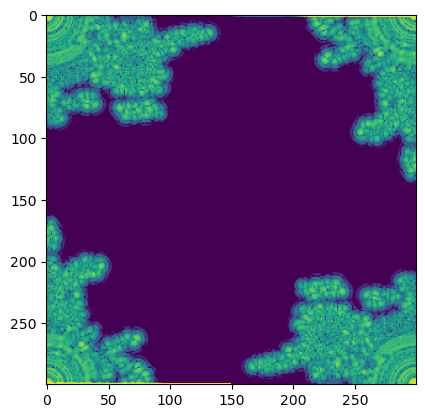

In [545]:
plt.clf()
plt.imshow(np.log(np.abs(vis_sol_full.real)),vmin=-12, vmax=-2)

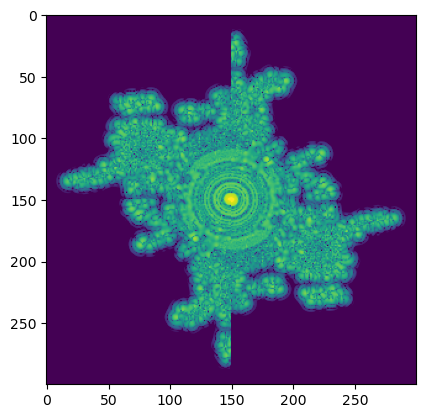

In [531]:
plt.clf()
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol_full.real))),vmin=-12, vmax=-2)

#### We calculate intensity

##### option 1: u > 0

In [895]:
intensity_reduced = np.fft.fftshift(np.fft.irfft2(vis_sol_reduced, s=(FT._Nx, FT._Ny)))/(FT._dx * FT._dy)

In [896]:
frank2d.sol_intensity = intensity_reduced

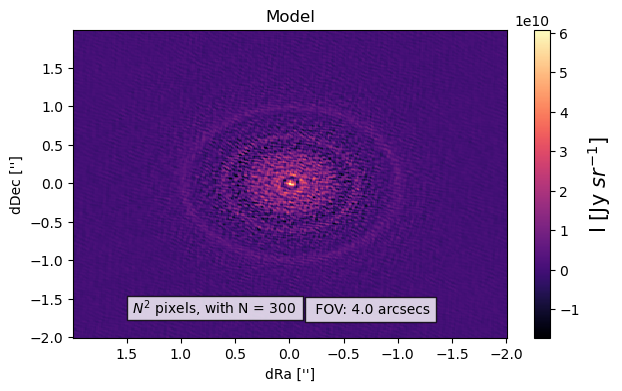

In [897]:
Plot(frank2d).get_image()

##### option 2: v>0

In [647]:
intensity_reduced_2 = np.fft.fftshift(np.fft.irfft2(vis_sol_reduced_2, s=(FT._Nx, FT._Ny)))/(FT._dx * FT._dy)

In [648]:
frank2d.sol_intensity = intensity_reduced_2

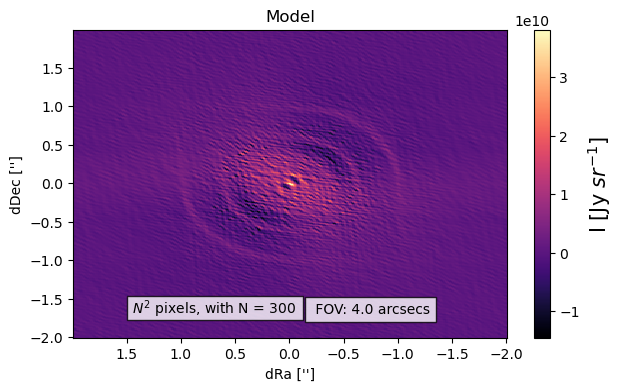

In [649]:
Plot(frank2d).get_image()

#### Let's try to calculate model visibilities using RFFT2

In [759]:
vis_reduced = np.fft.rfft2(intensity_reduced) * (FT._dx * FT._dy)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_62403/886906327.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(vis_reduced.real)), vmin=-12, vmax=-2)


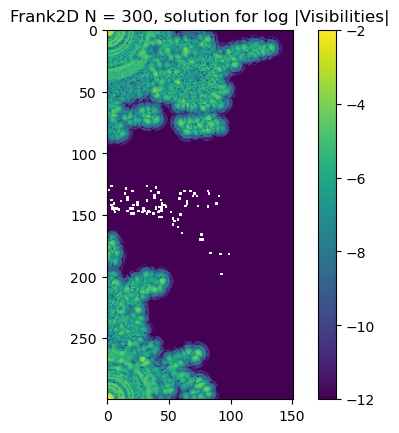

In [760]:
plt.imshow(np.log(np.abs(vis_reduced.real)), vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

In [761]:
vis_full_reconstructed = np.zeros((FT._Nx, FT._Ny), dtype=complex)

vis_full_reconstructed[:FT._Nx // 2, FT._Ny // 2:] = vis_reduced[FT._Nx // 2:,:-1]
vis_full_reconstructed[FT._Nx // 2:, FT._Ny // 2:] = vis_reduced[:FT._Nx // 2,:-1]

In [763]:
vis_full_reconstructed_right = vis_full_reconstructed[:, FT._Ny //2:]

In [765]:
# constructing top-left panel
vis_full_reconstructed[1:(FT._Nx // 2-1), :FT._Ny // 2] = np.conj(
    np.flip(vis_full_reconstructed_right[(FT._Nx//2+2):, :], axis=(0, 1))
)

# constructing bottom-left panel
vis_full_reconstructed[FT._Nx // 2-1:, :FT._Ny // 2] = np.conj(
    np.flip(vis_full_reconstructed_right[1:FT._Nx // 2+2, :], axis=(0, 1))
)

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_62403/1798957246.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(vis_full_reconstructed.real)), vmin=-12, vmax=-2)


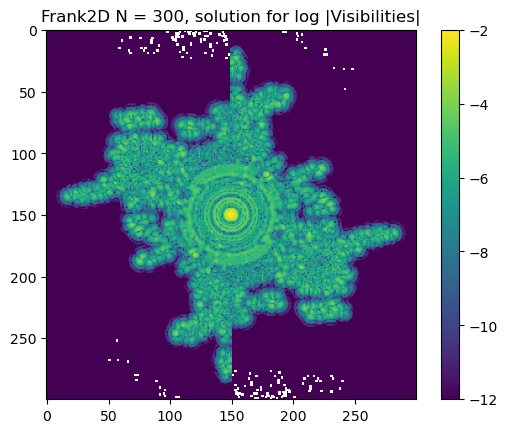

In [767]:
plt.clf()
plt.imshow(np.log(np.abs(vis_full_reconstructed.real)), vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

#### Imposing hermitian symmetry in visibilities considering all visibilities

In [858]:
def enforce_hermitian_symmetry_shifted(vis):
    N_x, N_y = vis.shape
    vis_symmetric = vis.copy()

    center_x, center_y = N_x // 2, N_y // 2

    for i in range(center_x, N_x):  # Recorrer la mitad derecha
        for j in range(N_y):   
            i_sym = (2 * center_x - i) % N_x
            j_sym = (2 * center_y - j) % N_y

            v_uv = vis_symmetric[i, j]
            v_neg_uv = vis_symmetric[i_sym, j_sym]

            if np.abs(v_neg_uv.real) > np.abs(v_uv.real):
                vis_symmetric[i, j] = np.conj(v_neg_uv)
            elif np.abs(v_neg_uv.real) < np.abs(v_uv.real):
                vis_symmetric[i_sym, j_sym] = np.conj(v_uv)
            else:
                vis_symmetric[i_sym, j_sym] = v_uv

    return vis_symmetric
vis_hermitian = enforce_hermitian_symmetry_shifted(np.fft.fftshift(vis_sol))

In [859]:
np.mean(vis_hermitian)

(0.00030650636040409124-3.440838428093869e-06j)

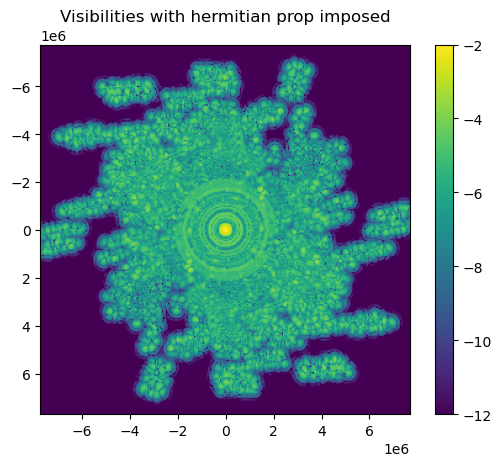

In [860]:
extent=[v_gridded.min(), v_gridded.max(), u_gridded.max(), u_gridded.min()]
plt.imshow(np.log(np.abs(vis_hermitian.real)),extent = extent, vmin=-12, vmax=-2)
plt.colorbar()
plt.title("Visibilities with hermitian prop imposed")
plt.show()

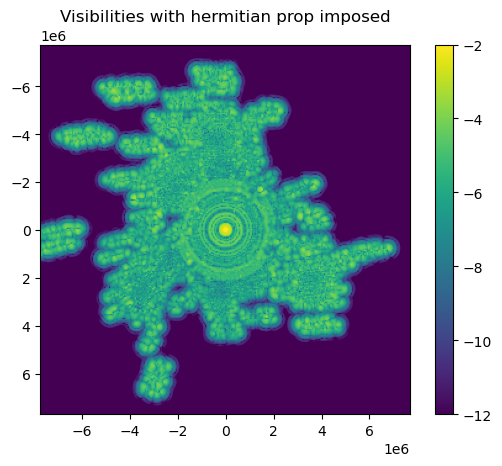

In [861]:
extent=[v_gridded.min(), v_gridded.max(), u_gridded.max(), u_gridded.min()]
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_sol))),extent = extent, vmin=-12, vmax=-2)
plt.colorbar()
plt.title("Visibilities with hermitian prop imposed")
plt.show()

In [866]:
vis_hermitian_reduced = np.fft.fftshift(vis_hermitian)[:, :FT._Ny//2]
intensity_hermitian_reduced = np.fft.fftshift(np.fft.irfft2(vis_hermitian_reduced, s=(FT._Nx, FT._Ny)))/(FT._dx * FT._dy)

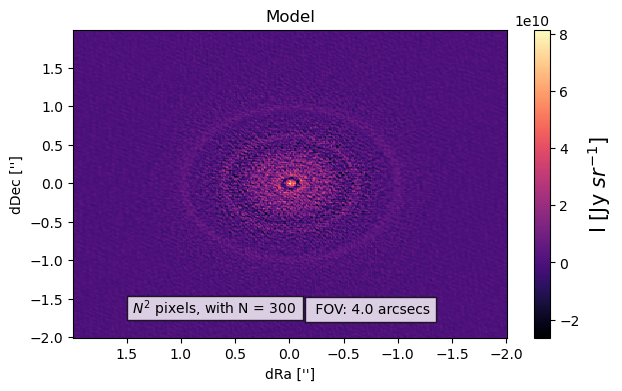

In [867]:
frank2d.sol_intensity = intensity_hermitian_reduced
Plot(frank2d).get_image()

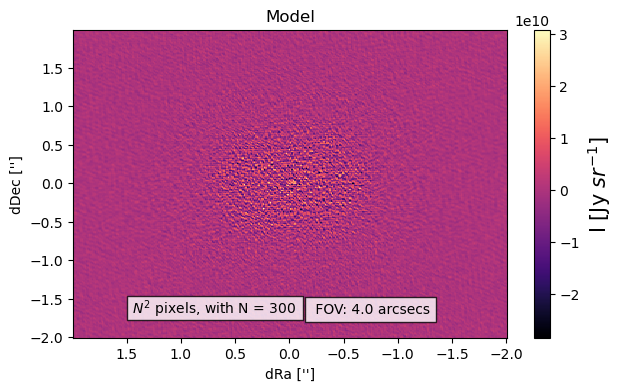

In [873]:
frank2d.sol_intensity = intensity_hermitian_reduced - intensity_reduced
Plot(frank2d).get_image()